### TP Apprentissage par renforcement 2/2

Dans cette séance, nous allons utiliser des implémentations existantes d'algorithmes d'apprentissage par renforcement (par exemple DQN), avec la librairire stable-baselines, et voir comment arriver à régler 
les paramètres de l'algorithme pour améliorer les performances. 

Il y a d'abord un certain nombre de choses à installer (décommentez les lignes ci-dessous): 

In [1]:
#!pip install stable-baselines3\[extra\]
#!pip install git+https://github.com/carlosluis/stable-baselines3@fix_tests
#!pip install pyglet==1.5.27
#!pip install pygame tqdm ipywidgets
# attention stablebaselines va installer openAI gym 0.26 -> change l'api d'affichage

In [31]:
# pour s'adapter à colab
import sys, os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

In [1]:
# pour lire des videos locales facilement
from tqdm import tqdm 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import matplotlib.cm as cm

from base64 import b64encode
from IPython.display import HTML


def play_video(v_path,width=400):
      mp4 = open(v_path,'rb').read()
      data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
      return HTML("""
          <video width=%d controls>
          <source src="%s" type="video/mp4">
          </video>
          """ % (width,data_url))

# images sauvées pendant la simulation -> video 
def make_video(images,outfile="movie.mp4"):
    fig = plt.figure()
    img_frames = []
    for img in tqdm(images):
        img_frames.append([plt.imshow(img,cmap=cm.Greys_r,animated=True)])
    ani = animation.ArtistAnimation(fig, img_frames, interval=50, blit=True,
                                repeat_delay=1000)
    ani.save(outfile)

Nous allons tenter de résoudre le problème suivant: une voiture essaie de monter une pente, mais son moteur n'est pas assez puissant pour y aller directement: 
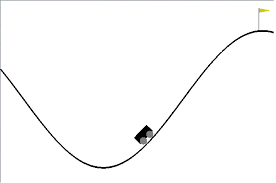

Ce problème fait partie des environnements implémentés dans OpenAI gym

In [16]:
import gym


# render_mode changement d'API passage 0.25 -> 0.26 
env = gym.make('MountainCar-v0',render_mode="rgb_array_list")

In [17]:
gym.__version__

'0.26.2'

In [22]:
# on récupère aussi une implémentation de DQN dans stable_baselines
from stable_baselines3 import DQN

#Valeurs par défaut pour DQN (copier cette cellule avant de faire des changements)
kwargs0 = {"learning_rate":0.0001, 
              "buffer_size":1_000_000, 
              "learning_starts":50000, 
              "batch_size":32, 
              "gamma":0.99, 
              "train_freq":4, 
              "gradient_steps":1, 
              "target_update_interval":10000, 
              "exploration_fraction":0.1, 
              "exploration_initial_eps":1.0, 
              "exploration_final_eps":0.05, 
              "max_grad_norm":10, 
              "policy_kwargs":None, 
         }

# On peut aussi modifier le réseau de neurones par défaut, qui est un perceptron multi-couches,
# en spécifiant les tailles des couches cachées: ici 2 couches chacune de taille 32
kwargs0["policy_kwargs"] = dict(net_arch=[32, 32])

Reprenons le schéma de l'algorithme DQN vu en cours :

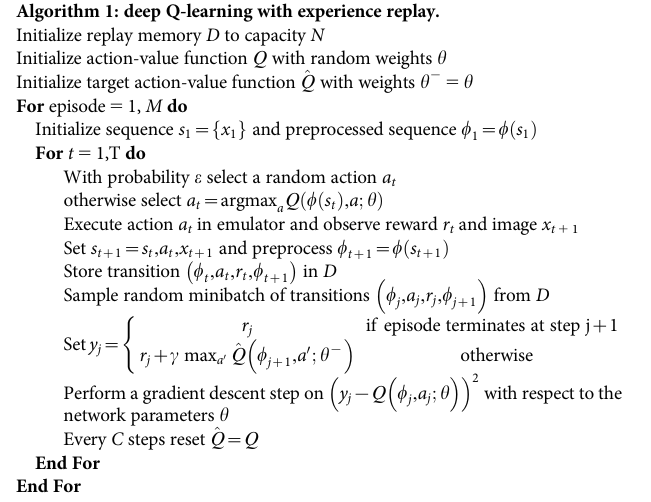

Signification des hyper-paramètres: (voir aussi https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html)

- buffer_size: taille de la mémoire (memory replay)
- exploration_final_eps/initial/fraction: l'epsilon qui décide la probabilité d'exploration au hasard peut être dynamique: ici il démarre avec une certaine valeur (initial), est diminué régulièrement (en * par fraction), jusqu'à atteindre la valeur finale, ou il restera alors constant. 
- learning_starts: nombre de pas dans l'environnement qui sont stockés avant de commencer l'entrainement du réseau
- target_update_interval: au bout de combien de pas on met à jour le réseau Q cible (=C dans l'algo ci-dessus)
- train_freq: mise à jour du modèle tous les n steps

### A faire : 
Les parametres par défaut ne sont pas adaptés au problème ici, et il faut donc essayer de changer : 

- la taille du memory replay (pas trop gros)
- du coup quel autre paramètre faut-il changer ? réponse learning_starts + target update interval
- le perceptron de départ n'a pas assez de paramètres: essayer d'augmenter la taille de la/des couches cachées
- relever le learning rate si rien ne se passe (10^n en augmentant n)
- taille des batchs + train freq (32,64,128) // (4,8,16)
- gradient steps: mettre 8
- seulement quand le training commence à être mieux -> allonger le nb de steps de l'entrainement


Pour surveiller commence se passe l'entrainement, on va enregistrer ce qui se passe dans un fichier annexe:

In [24]:
from stable_baselines3.common.logger import configure

tmp_path = "/tmp/sb3_log/"
#on efface le précédent sinon tout se cumule dans le même fichier; à adapter pour windoz
!rm $tmp_path/progress.csv
new_logger = configure(tmp_path, ["csv"])

In [26]:
# commencer à 20/40_000 max pour le nb de pas, et n'augmentez pas avant que la courbe ait l'air de séaméliorer
model = DQN("MlpPolicy", env, verbose=1,**kwargs0)
model.set_logger(new_logger)
model.learn(total_timesteps=40_000,progress_bar=True)

Output()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [2]:
import pandas as pds
#!ls $tmp_path
log = pds.read_csv(tmp_path+"/progress.csv")
log.columns
# cf https://stable-baselines3.readthedocs.io/en/master/common/logger.html

In [33]:
log.tail()

,time/episodes,time/time_elapsed,rollout/ep_rew_mean,rollout/ep_len_mean,time/total_timesteps,rollout/exploration_rate,time/fps
20,84,36,-200.0,200.0,16800,0.05,462
21,88,38,-200.0,200.0,17600,0.05,461
22,92,39,-200.0,200.0,18400,0.05,461
23,96,41,-200.0,200.0,19200,0.05,460
24,100,43,-200.0,200.0,20000,0.05,460


In [35]:
#log.plot(x="time/total_timesteps",y="train/loss")

<AxesSubplot: xlabel='time/total_timesteps'>

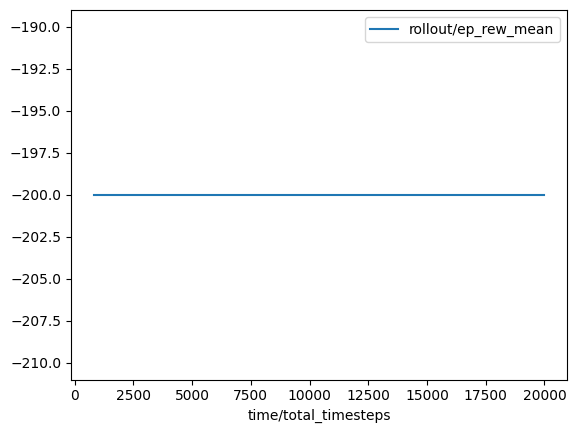

In [31]:
log.plot(x="time/total_timesteps",y="rollout/ep_rew_mean")

In [36]:
# ne marchera pas tant que la mean reward à l'entrainement n'est pas au moins à -140/-120
obs = env.reset()[0]
for i in range(1000):
    action, *_state = model.predict(obs,deterministic=False)
    obs, reward, done, *info = env.step(action)
    #env.render()
    if done:
        #obs = env.reset()
        break

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:01<00:00, 828.88it/s]


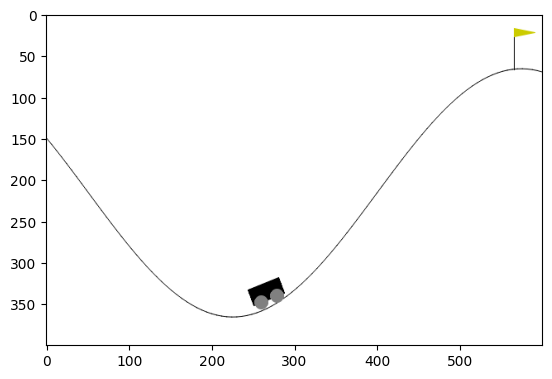

In [37]:
images = env.render()
make_video(images,"movie.mp4")
play_video("movie.mp4",width=600)

### Transposition à un autre problème 

Essayez de voir si un modèle DQN avec les mêmes paramètres peut marcher avec un autre environnement, par exemple le Lunar Lander. Comparez avec les arguments par défaut, et comparer avec l'algorithme PPO (Proximal Policy Optimization) de stable-baseline, avec les arguments par défaut.

In [54]:
#!pip install gym\[Box2D\]

In [70]:
from stable_baselines3 import PPO

In [55]:
env = gym.make('LunarLander-v2',render_mode="rgb_array_list")
#options fun à changer: 
# gravity: float = -10.0,
# enable_wind: bool = False,
# wind_power: float = 15.0,
# turbulence_power: float = 1.5,